In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib2, json
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2
################api info
api_key = 'J0LLMPESJ7H0SKXQ'
ticker = "SPX"
################


###########train&test hyper parameter
test_sz =500
bz_size =128
day_unroll = 20 # 20 days info
week_unroll =12  # 12 weeks info to predict the next day, next week,next month
                                    #day                #1week              #4week
output_normalize_dict = np.array([ [20,0.0157, 0.038]])
                                   #, [1,0.002,0.0085],[1,0.004, 0.0191], [4,0.0157, 0.038] ] )
predict_type = 'binary' # binary 4class binary+4class


############# LSTM model architecture
#lstm with 3 layers each with dimension as followed
num_nodes = [300,200,250]
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount


#########learning paramters
iterations = 400
learning_rate= 0.01
min_learning_rate= 0.0005

In [3]:


    # JSON file with all the stock market data for AAL from the last 20 years
url_string_day  = \
"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
url_string_week = \
"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
    # Save data to this file
file_to_save_day  = 'stock_market_data_day-%s.csv'%ticker
file_to_save_week = 'stock_market_data_week-%s.csv'%ticker
    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
if (not os.path.exists(file_to_save_day)) or (not os.path.exists(file_to_save_week)):
    url_day = urllib2.urlopen(url_string_day)
    data_day = json.loads(url_day.read().decode())
    
    url_week = urllib2.urlopen(url_string_week)
    data_week = json.loads(url_week.read().decode())
    # extract stock market data
    data_day = data_day['Time Series (Daily)']
    data_week = data_week['Weekly Time Series']
    df_day  = pd.DataFrame(columns=['Date','Mid' ,'Volume'])
    df_week = pd.DataFrame(columns=['Date','Mid' ,'Volume'])
    for k,v in data_day.items():
        date = dt.datetime.strptime(k, '%Y-%m-%d')
        data_row = [date.date(),(float(v['3. low'])+float(v['2. high']))/2, float(v['5. volume'])]
        df_day.loc[-1,:] = data_row
        df_day.index = df_day.index + 1
    print('Data saved to : %s'%file_to_save_day)
    df_day = df_day.sort_values('Date')
    df_day.to_csv(file_to_save_day)
        
    for k,v in data_week.items():
        date = dt.datetime.strptime(k, '%Y-%m-%d')
        data_row = [date.date(),(float(v['3. low'])+float(v['2. high']))/2, float(v['5. volume'])]
        df_week.loc[-1,:] = data_row
        df_week.index = df_week.index + 1
    print('Data saved to : %s'%file_to_save_week)
    df_week = df_week.sort_values('Date')
    df_week.to_csv(file_to_save_week)

    # If the data is already there, just load it from the CSV
else:
        print('File already exists. Loading data from CSV')
        df_day = pd.read_csv(file_to_save_day)
        df_week = pd.read_csv(file_to_save_week)

Data saved to : stock_market_data_day-SPX.csv
Data saved to : stock_market_data_week-SPX.csv


[2633.0266317057267 5441347401.748089]
[2657.1611592066374 26198662660.7535]
[ 0.08080353  1.61883461]
[ 0.08524494  1.46673136]
(4371, 2)
(917, 2)


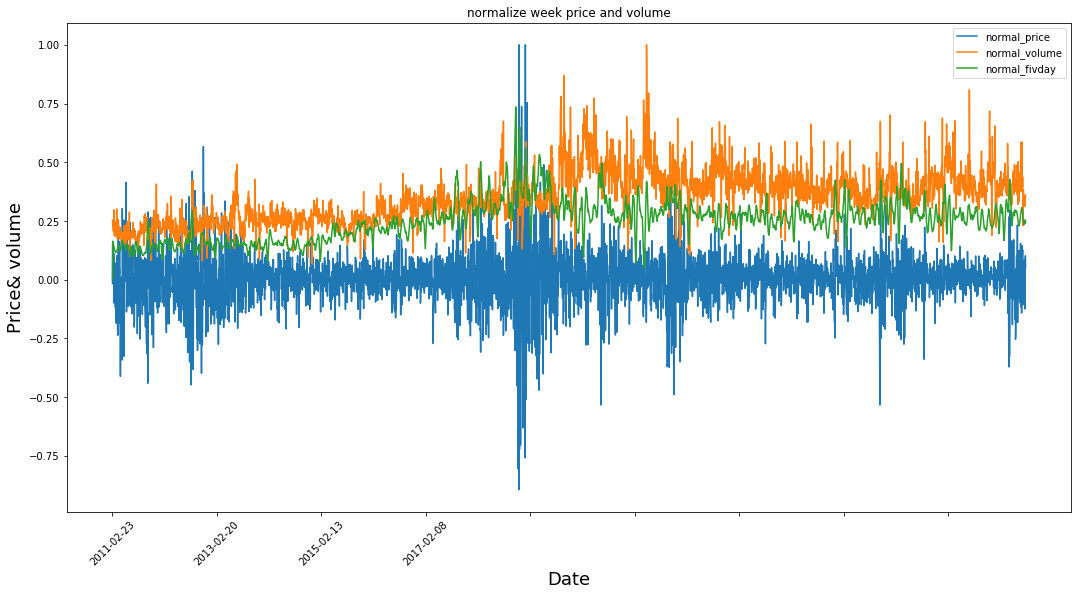

In [4]:
pre_train_data_day  =  df_day.loc[:,['Mid','Volume']].as_matrix()
pre_train_data_week =  df_week.loc[:,['Mid','Volume']].as_matrix()

#align pre_train_data_data with data week
align=0
while(df_day['Date'].loc[align] <=df_week['Date'].loc[0]):
    align=align+1

pre_train_data_day = pre_train_data_day[align:]
    
total_day_1y = 52*5
total_week_1y =52-9

train_data_day  = np.zeros(( pre_train_data_day.shape[0] - total_day_1y,2))
day_week_map    = np.zeros(( pre_train_data_day.shape[0] - total_day_1y)) #map day to corresponing week data
train_data_week = np.zeros(( pre_train_data_week.shape[0]-total_week_1y,2))
j=0
for i in range(0, train_data_day.shape[0]):
    if j>= train_data_week.shape[0]:
        day_week_map[i] =j
    else:
        while ( df_day['Date'].loc[i+align+total_day_1y] >df_week['Date'].loc[j+total_week_1y]):
            j= j+1
            if j>= train_data_week.shape[0]: break
        day_week_map[i] =j-1




#discard first year data for moving average
average_day = np.mean( pre_train_data_day, axis=0) 
average_week = np.mean( pre_train_data_week, axis=0) 



EMA = np.array(0)
for i in range(0, train_data_day.shape[0]):
    average_day = average_day+ (pre_train_data_day[i+total_day_1y]- pre_train_data_day[i])/ total_day_1y
    train_data_day[i,0] =  (pre_train_data_day[i+total_day_1y,0]- pre_train_data_day[i-1+total_day_1y,0])/pre_train_data_day[i-1+total_day_1y,0]
    train_data_day[i,1:] = (pre_train_data_day[i+total_week_1y,1:]/(average_day[1:]))*0.95+  EMA*0.05
    #train_data_day[i] = (pre_train_data_day[i+total_day_1y]) *0.95 + EMA*0.05
    EMA = train_data_day[i, 1:]
for i in range(0,train_data_week.shape[0]):
    average_week = average_week+ (pre_train_data_week[i+total_week_1y]- pre_train_data_week[i])/ total_week_1y
    train_data_week[i,0] =  (pre_train_data_week[i+total_week_1y,0]- pre_train_data_week[i-1+total_week_1y,0])/pre_train_data_week[i-1+total_week_1y,0]
    train_data_week[i,1:] = (pre_train_data_week[i+total_week_1y,1:]/(average_week[1:]))*0.95+  EMA*0.05
    EMA = train_data_week[i,1:]

five_day_avg      = pre_train_data_day
average_fiveday = average_day
for i in range(6, five_day_avg.shape[0]):
    five_day_avg[i]= five_day_avg[i-1]+0.2*(pre_train_data_day[i]-pre_train_data_day[i-5])
five_day_avg_norm = np.zeros(( five_day_avg.shape[0]-total_day_1y ,2))
for i in range(1,five_day_avg_norm.shape[0]):
        average_fiveday = average_fiveday+ (five_day_avg[i+total_day_1y]- five_day_avg[i])/ total_day_1y
        five_day_avg_norm[i,0]  =   (five_day_avg[i+total_day_1y,0]- five_day_avg[i+total_day_1y-5,0])/ five_day_avg[i+total_day_1y-5,0]
        five_day_avg_norm[i,1:] =   (five_day_avg[i+total_day_1y,1:]/(average_fiveday[1:]))*0.95+  EMA*0.05
        EMA =five_day_avg_norm[i,1:]
print average_day
print average_week
    
average_train_day = np.amax(train_data_day, axis=0)
average_train_week = np.amax(train_data_week, axis=0)
print average_train_day
print average_train_week
train_data_day = train_data_day/ average_train_day
five_day_avg_norm = five_day_avg_norm/average_train_day
train_data_week = train_data_week/ average_train_week
ori_data_day = pre_train_data_day[total_day_1y:]
ori_data_week= pre_train_data_week[total_week_1y:]
print train_data_day.shape
print train_data_week.shape
plt.figure(figsize = (18,9))
plt.plot( range(train_data_day.shape[0]),  train_data_day[:,0], label='normal_price')
plt.plot( range(train_data_day.shape[0]),  train_data_day[:,1], label='normal_volume')
plt.plot( range(train_data_day.shape[0]),  five_day_avg_norm[:,1], label='normal_fivday')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price& volume',fontsize=18)
plt.xticks(range(0,train_data_day.shape[0], 500),df_day['Date'].loc[total_day_1y+align::500],rotation=45)
plt.title("normalize week price and volume")
plt.legend()
plt.show()

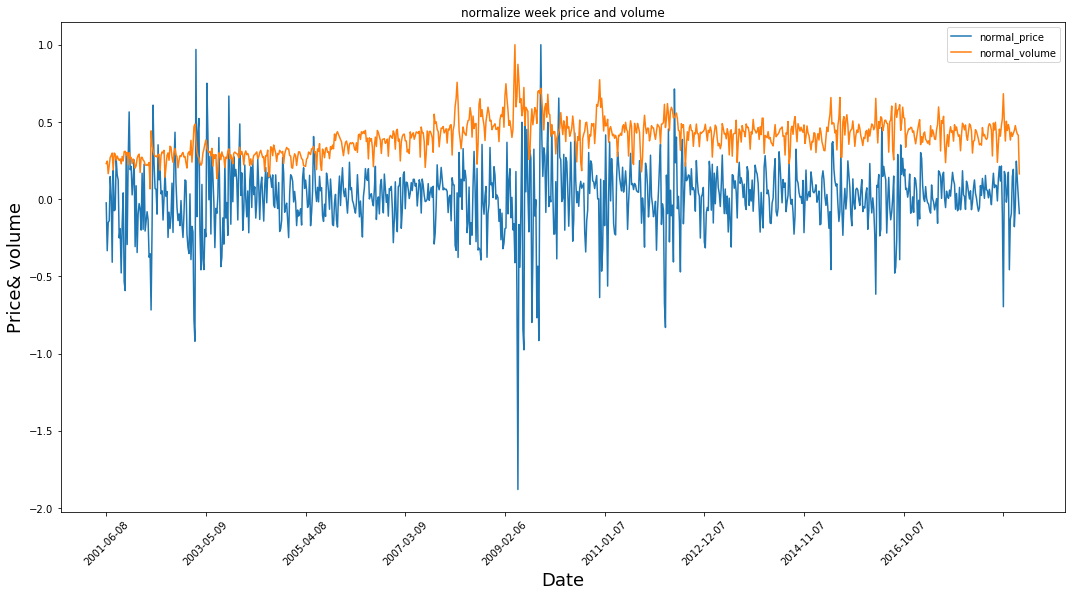

In [20]:
plt.figure(figsize = (18,9))
plt.plot( range(train_data_week.shape[0]),  train_data_week[:,0], label='normal_price')
plt.plot( range(train_data_week.shape[0]),  train_data_week[:,1], label='normal_volume')

plt.xlabel('Date',fontsize=18)
plt.ylabel('Price& volume',fontsize=18) 
plt.xticks(range(0,train_data_week.shape[0], 100),df_week['Date'].loc[total_week_1y::100],rotation=45)
plt.title("normalize week price and volume")
plt.legend()
plt.show()

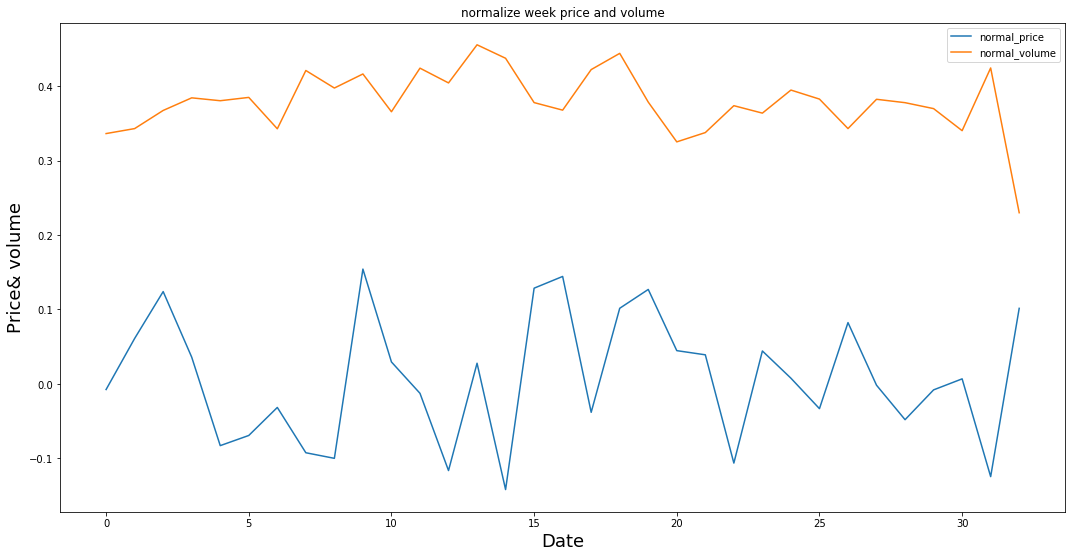

In [14]:
test_day = ('clean_python2/test/stock_market_data_day-%s.csv'%ticker)
test_week= ('clean_python2/test/stock_market_data_week-%s.csv'%ticker)
df_day = pd.read_csv(test_day)
df_week = pd.read_csv(test_week)

pre_test_data_day  =  df_day.loc[:,['Mid','Volume']].as_matrix()
pre_test_data_week =  df_week.loc[:,['Mid','Volume']].as_matrix()

#align pre_train_data_data with data week
align=0
while(df_day['Date'].loc[align] <=df_week['Date'].loc[0]):
    align=align+1
pre_test_data_day = pre_test_data_day[align:]
test_data_day  = np.zeros(( pre_test_data_day.shape[0] ,2))
day_week_map    = np.zeros(( pre_test_data_day.shape[0] )) #map day to corresponing week data
test_data_week = np.zeros(( pre_test_data_week.shape[0],2))

j=0
for i in range(0, test_data_day.shape[0]): 
    if j>= test_data_week.shape[0]:
        day_week_map[i]=j
    else:
        while ( df_day['Date'].loc[i+align] >df_week['Date'].loc[j]):
            j= j+1
            if j>= test_data_week.shape[0]:
                day_week_map[i] =j 
                break
            else:
                day_week_map[i] =j-1

train_data_max_day  = [0.081, 1.619*(5.44e+09)]
train_data_max_week = [0.085, 1.46*(2.64e+10)]
for i in range(1, test_data_day.shape[0]):
    test_data_day[i,0] =  (pre_test_data_day[i,0]- pre_test_data_day[i-1,0])/ (train_data_max_day[0]*pre_test_data_day[i-1,0])
    test_data_day[i,1:] = (pre_test_data_day[i,1:]/(train_data_max_day[1:]))

for i in range(1, test_data_week.shape[0]):
    test_data_week[i,0] =  (pre_test_data_week[i,0]- pre_test_data_week[i-1,0])/(train_data_max_week[0]*pre_test_data_week[i-1,0])
    test_data_week[i,1:] = (pre_test_data_week[i,1:]/(train_data_max_week[1:]))
    
plt.figure(figsize = (18,9))
plt.plot( range(test_data_day.shape[0]-1),  test_data_day[1:,0], label='normal_price')
plt.plot( range(test_data_day.shape[0]-1),  test_data_day[1:,1], label='normal_volume')

plt.xlabel('Date',fontsize=18)
plt.ylabel('Price& volume',fontsize=18)

plt.title("normalize week price and volume")
plt.legend()
plt.show()


In [5]:
class DataGeneratorSeq(object):

    def __init__(self,day_data, week_data,batch_size,num_day_unroll,\
                 num_week_unroll,output_norm_dict, day_week_map, test_sz, ori_data_day, ori_data_week, predict_type ='binary'):
        self._day_data = day_data
        self._week_data = week_data
        self._day_week_map= day_week_map
        self._output_norm_dict = output_norm_dict
        self._day_length = len(self._day_data) - num_day_unroll - output_norm_dict[output_norm_dict.shape[0]-1,0]*5-test_sz
        self._batch_size = batch_size
        self._num_week_unroll = num_week_unroll
        self._num_day_unroll = num_day_unroll
        self._segments = self._day_length //self._batch_size
        self._cursor = [(offset+1) * self._segments-1 for offset in range(self._batch_size)]
        self._test_cursor =  np.random.randint( self._day_length+num_day_unroll,\
                                               len(self._day_data)-1-output_norm_dict[output_norm_dict.shape[0]-1,0]*5, size=[self._batch_size])
        self.predict_type = predict_type
        self.ori_data_day  = ori_data_day # non normalize price
        self.ori_data_week = ori_data_week #non normalize price
        self.test_sz = test_sz

    def _get_labels(self, test= False):
        day_data = self.ori_data_day
        week_data = self.ori_data_week
        cursor = self._test_cursor if(test) else self._cursor
        
        if self.predict_type == 'binary':
            batch_labels = np.zeros((self._batch_size, self._output_norm_dict.shape[0], 2),dtype=np.float32)
        elif self.predict_type == '4class': 
            batch_labels = np.zeros((self._batch_size, self._output_norm_dict.shape[0], 4),dtype=np.float32)
            
        for b in range(self._batch_size):    
            for j in range(0,self._output_norm_dict.shape[0]):
                if not j==0:
                    result=  \
                    (week_data[ int(self._day_week_map[int(cursor[b])]+self._output_norm_dict[j,0]),0]\
                    -week_data[ int(self._day_week_map[int(cursor[b])]),0])/week_data[ int(self._day_week_map[int(cursor[b])]),0]
                else:
                    result =  (day_data[int(cursor[b]+self._output_norm_dict[0,0]),0]- 
                                                  day_data[int(cursor[b]),0])/day_data[int(cursor[b]),0]
                if self.predict_type=='binary': batch_labels[b,0,:]=(np.array([0,1]) if result>=0 else np.array([1,0]))   
                if self.predict_type=='4class':
                    batch_labels[b,j]  = np.zeros((4), dtype=np.float32)
                    if  (result>self._output_norm_dict[j,1]):     batch_labels[b,j,3]=1  
                    elif(result>0):                               batch_labels[b,j,2]=1  
                    elif(result<-1*self._output_norm_dict[j,1]):  batch_labels[b,j,0]=1 
                    else:  batch_labels[b,j,1]=1  
                    
               
        #print self._output_norm_dict[0,0], self._cursor[0]+self._output_norm_dict[0,0], batch_labels[0,0]
       
        return batch_labels
    def _get_onestep_weekbatch(self, i, test=False):
        cursor = self._test_cursor if(test) else self._cursor
        week_batch_data = np.zeros((self._batch_size, self._day_data.shape[1]),dtype=np.float32)
        for b in range(self._batch_size):
            week_batch_data[b] = self._week_data[int(self._day_week_map[int(cursor[b])]-i)]
        return week_batch_data
    def _get_onestep_daybatch(self,i, test=False):
        cursor = self._test_cursor if(test) else self._cursor
        day_batch_data = np.zeros((self._batch_size, self._day_data.shape[1]),dtype=np.float32)
        for b in range(self._batch_size):
            k=int(cursor[b]-i)
            day_batch_data[b] = self._day_data[k]
        return day_batch_data
   

    def onestep_unroll(self, test=False):

        unroll_weekdata,unroll_daydata = [],[]
        for i in range(self._num_day_unroll):
            unroll_daydata.append(self._get_onestep_daybatch(self._num_day_unroll-1-i, test))
        for i in range(self._num_week_unroll):
            unroll_weekdata.append(self._get_onestep_weekbatch(self._num_week_unroll-i, test))

        onestep_label=self._get_labels(test)
        #update label
        self.reset_indices(test)
        unroll_daydata  = np.transpose( unroll_daydata,  (1, 0, 2))
        unroll_weekdata = np.transpose( unroll_weekdata, (1, 0, 2))
        return unroll_daydata, unroll_weekdata, onestep_label

    def reset_indices(self, test=False):
        if(not test):
            for b in range(self._batch_size):
                self._cursor[b] = \
                np.random.randint( max((b) * self._segments, self._num_day_unroll), (b+1)*self._segments-1)
        else:
            self._test_cursor =  np.random.randint( self._day_length+self._num_day_unroll,\
                                               len(self._day_data)-1-self._output_norm_dict[self._output_norm_dict.shape[0]-1,0]*5, size=[self._batch_size])
    
    def run_all_test(self, i,test=True):
        # i the start of tests
        self._test_cursor = np.arange(i, i+self._batch_size)
        a,b,c = self.onestep_unroll(test=True)
        return a, b, c
dg = \
DataGeneratorSeq(train_data_day, train_data_week, bz_size , \
                 day_unroll, week_unroll,output_normalize_dict, day_week_map, test_sz,  ori_data_day, ori_data_week, predict_type=predict_type)
daydata, weekdata, label=dg.onestep_unroll()
print label.shape
#test_cursor = dg._cursor
#for i in range(len(test_cursor)):
#    print df_day['Date'].loc[test_cursor[i]+total_day_1y+align],\
#    df_day['Mid'].loc[test_cursor[i]+total_day_1y+align]

print label



(128, 1, 2)
[[[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  1.]]

 [[ 1.  0.]]

 [[ 1.  0.]]

 [[ 0.  

In [62]:
# Create the graph object
# main tesnor flow model

class train_model(object):
    def __init__(self, day_unroll, week_unroll, batch_size, output_norm_dict, num_nodes, learning_rate, min_learning_rate, day_feature, week_feature, n_hot=2):
        self.global_steps =tf.Variable(0,name='global_steps',trainable=False)
        self.dropout = tf.placeholder (tf.float32, name='dropout')
        self.n_hot = n_hot
        self.train_inputs_day = tf.placeholder(tf.float32, shape=[batch_size, day_unroll, day_feature],name='train_dayinputs')
        self.train_inputs_week=tf.placeholder(tf.float32, shape=[batch_size, week_unroll, week_feature],name='train_weekinputs')
        self.learning_rate= tf.Variable(learning_rate,name='tf_learning_rate')
        self.label_sz =  output_norm_dict.shape[0]
        self.label = tf.placeholder(tf.float32, shape=[batch_size, output_norm_dict.shape[0], n_hot], name = 'train_outputs')
        self.tf_learning_rate =     tf.Variable(learning_rate,name='tf_learning_rate')
        self.tf_min_learning_rate = tf.Variable(min_learning_rate,dtype=tf.float32,name='tf_min_learning_rate')
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self._build_model()
        self._compute_loss()
        self._optimizer()
        #self.is_train = tf.placeholder (tf.bool, name='is_train')
    
    def _build_model(self):
        
        day_lstm_cells = [
            tf.contrib.rnn.LSTMCell(num_units=self.num_nodes[li],
                                    state_is_tuple=True,
                                    initializer= tf.contrib.layers.xavier_initializer()
                                   )
         for li in range(n_layers)]

        week_lstm_cells = [
            tf.contrib.rnn.LSTMCell(num_units=self.num_nodes[li],
                                    state_is_tuple=True,
                                    initializer= tf.contrib.layers.xavier_initializer()
                                   )
         for li in range(n_layers)]

        drop_day_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0,output_keep_prob=1.0-self.dropout, state_keep_prob=1.0-self.dropout
        ) for lstm in day_lstm_cells]
        drop_week_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0,output_keep_prob=1.0-self.dropout, state_keep_prob=1.0-self.dropout
        ) for lstm in week_lstm_cells]

        drop_day_multi_cell      = tf.contrib.rnn.MultiRNNCell(drop_day_lstm_cells)
        drop_week_multi_cell     = tf.contrib.rnn.MultiRNNCell(drop_week_lstm_cells)
        self.initial_state_day        = drop_day_multi_cell.zero_state(self.batch_size, tf.float32)
        self.initial_state_week       = drop_week_multi_cell.zero_state(self.batch_size, tf.float32)

        #outputs_day shape=[batch_size, max_time, output feature size]
        outputs_day,  final_state_day  = tf.nn.dynamic_rnn(drop_day_multi_cell, self.train_inputs_day, 
                                          time_major=False, dtype=tf.float32, scope='lstm_day', initial_state = self.initial_state_day)

        outputs_week, final_state_week = tf.nn.dynamic_rnn(drop_week_multi_cell, self.train_inputs_week, 
                                          time_major=False,dtype=tf.float32, scope='lstm_week', initial_state=self.initial_state_week)
        self.output_blend =  tf.concat([outputs_day, outputs_week], axis=1)
        self.output_blend = tf.squeeze(self.output_blend[:, -1])
    def _compute_loss(self):
        self.predictions_pre = tf.contrib.layers.fully_connected(self.output_blend, 100, activation_fn=tf.nn.selu)
        self.predictions= tf.contrib.layers.fully_connected(self.predictions_pre, self.label_sz*self.n_hot, activation_fn=None)
        self.predictions = tf.reshape(self.predictions, shape=[-1,self.label_sz, self.n_hot])
        self.cost        = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=self.label, logits=self.predictions))

    def _optimizer(self):
        learning_rate = tf.maximum(tf.train.exponential_decay(\
        self.tf_learning_rate, self.global_steps, decay_steps=1, decay_rate=0.5, staircase=True),self.tf_min_learning_rate)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        gradients, v = zip(*optimizer.compute_gradients(self.cost))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer = optimizer.apply_gradients(
            zip(gradients, v),  global_step = self.global_steps)


In [63]:
### define train one step procedure
def train_one_step(sess,iteration, dg, tm):
    
    day_input, week_input, output_label = dg.onestep_unroll()
    feed = {tm.train_inputs_day: day_input, tm.train_inputs_week: week_input, tm.label:output_label, tm.dropout:0.2}
    _, step_cost, predictions = sess.run([tm.optimizer, tm.cost, tm.predictions], feed_dict=feed)
    correct = 1*np.equal( np.argmax(predictions, axis=2), np.argmax(output_label, axis=2)) 
    train_acc = np.mean( correct)
    
    if tm.n_hot>2:
        condense_predictions = np.zeros(( predictions.shape[0],  predictions.shape[1],  2))
        condense_predictions[:,:,0] = predictions[ :,:,0]
        condense_predictions[:,:,1] = predictions[ :,:,predictions.shape[2]//2]
        condense_label = np.zeros( (output_label.shape[0],  output_label.shape[1],  2))
        condense_label[:,:,0] = output_label[ :,:,0]
        condense_label[:,:,1] = output_label[ :,:,predictions.shape[2]//2]
        for i in range(1,predictions.shape[2]//2):
            condense_predictions[:,:,0] = condense_predictions[:,:,0]+ predictions[ :,:,i]
            condense_predictions[:,:,1] = condense_predictions[:,:,1]+ predictions[ :,:,i+predictions.shape[2]//2 ]
            condense_label[:,:,0] = condense_label[:,:,0]+ output_label[ :,:,i]
            condense_label[:,:,1] = condense_label[:,:,1]+ output_label[ :,:,i+predictions.shape[2]//2 ]
        
        condense_correct = 1*np.equal( np.argmax( condense_predictions, axis=2), np.argmax(condense_label, axis=2)) 
        condense_train_acc = np.mean(condense_correct)
    #print 'step:%d , cost:%f' % (iteration, step_cost)
    
    if (iteration%10 ==0):
        day_input, week_input, output_label = dg.onestep_unroll(test=True)
        feed = {tm.train_inputs_day: day_input, tm.train_inputs_week: week_input, tm.label:output_label, tm.dropout:0}
        test_cost, predictions = sess.run([tm.cost, tm.predictions], feed_dict=feed)
        correct = 1*np.equal( np.argmax(predictions, axis=2), np.argmax(output_label, axis=2)) 
        test_acc = np.mean( correct)
        if tm.n_hot>2:
            condense_predictions = np.zeros(( predictions.shape[0],  predictions.shape[1],  2))
            condense_predictions[:,:,0] = predictions[ :,:,0]
            condense_predictions[:,:,1] = predictions[ :,:,predictions.shape[2]//2]
            condense_label = np.zeros( ( output_label.shape[0],  output_label.shape[1],  2))
            condense_label[:,:,0] = output_label[ :,:,0]
            condense_label[:,:,1] = output_label[ :,:,predictions.shape[2]//2]
            for i in range(1,predictions.shape[2]//2):
                condense_predictions[:,:,0] = condense_predictions[:,:,0]+ predictions[ :,:,i]
                condense_predictions[:,:,1] = condense_predictions[:,:,1]+ predictions[ :,:,i+predictions.shape[2]//2 ]
                condense_label[:,:,0] = condense_label[:,:,0]+ output_label[ :,:,i]
                condense_label[:,:,1] = condense_label[:,:,1]+ output_label[ :,:,i+predictions.shape[2]//2 ]
            condense_correct = 1*np.equal( np.argmax( condense_predictions, axis=2), np.argmax(condense_label, axis=2)) 
            condense_test_acc = np.mean(condense_correct)
            print 'step:%d , train_acc:%f, train_acc_s:%f, test_acc:%f, test_acc_s:%f' % (iteration, train_acc, condense_train_acc, test_acc, condense_test_acc)
        else:
            print 'step:%d , train_acc:%f, test_acc:%f ' % (iteration, train_acc, test_acc)
    else: test_acc=0
    return train_acc, test_acc

In [64]:
### define test procedure
def test_all(sess, dg, tm):
    #overall test
    all_predictions = np.zeros( (1, 1,tm.n_hot))
    all_output = np.zeros((1, 1, tm.n_hot))
    for i in range( dg._day_data.shape[0]-dg.test_sz,dg._day_data.shape[0]-21-tm.batch_size,tm.batch_size):
        day_input, week_input, output_label = dg.run_all_test(i)
        feed = {tm.train_inputs_day: day_input, tm.train_inputs_week: week_input, tm.label:output_label, tm.dropout:0}
        predictions = sess.run([tm.predictions], feed_dict=feed)[0]
        all_predictions=np.append(all_predictions,predictions, axis=0)
        all_output=     np.append(all_output,output_label, axis=0)
    
    
    all_correct = 1*np.equal( np.argmax(all_predictions, axis=2), np.argmax(all_output, axis=2)) 
    train_acc = np.mean( all_correct)
    
    print 'test overall predictions:%s' % (train_acc)
    

step:0 , train_acc:0.398438, test_acc:0.796875 
step:10 , train_acc:0.593750, test_acc:0.804688 
step:20 , train_acc:0.640625, test_acc:0.750000 
step:30 , train_acc:0.640625, test_acc:0.804688 
step:40 , train_acc:0.578125, test_acc:0.789062 
step:50 , train_acc:0.632812, test_acc:0.796875 
step:60 , train_acc:0.632812, test_acc:0.796875 
step:70 , train_acc:0.632812, test_acc:0.781250 
step:80 , train_acc:0.562500, test_acc:0.734375 
step:90 , train_acc:0.648438, test_acc:0.757812 
step:100 , train_acc:0.546875, test_acc:0.734375 
step:110 , train_acc:0.585938, test_acc:0.835938 
step:120 , train_acc:0.609375, test_acc:0.757812 
step:130 , train_acc:0.562500, test_acc:0.828125 
step:140 , train_acc:0.625000, test_acc:0.804688 
step:150 , train_acc:0.593750, test_acc:0.757812 
step:160 , train_acc:0.617188, test_acc:0.773438 
step:170 , train_acc:0.703125, test_acc:0.781250 
step:180 , train_acc:0.609375, test_acc:0.781250 
step:190 , train_acc:0.664062, test_acc:0.789062 
step:200 , 

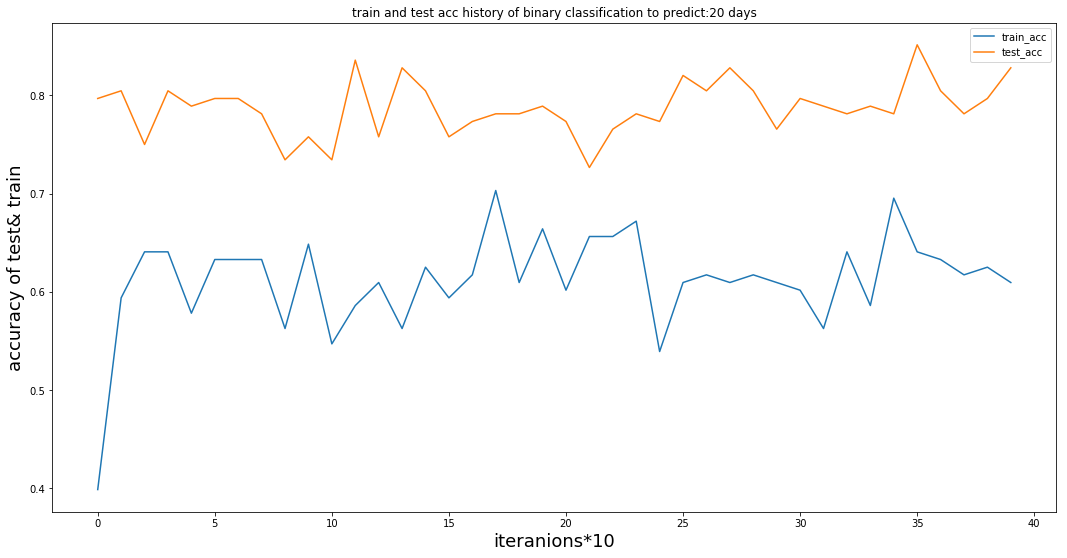

In [69]:
session_config = tf.ConfigProto(
                allow_soft_placement=True,
                gpu_options=tf.GPUOptions(allow_growth=True),
                device_count={'GPU': 1}
)

tf.reset_default_graph()


sess=tf.Session(config=session_config)
if predict_type=='binary': n_hot=2
if predict_type=='4class': n_hot=4

tm =  train_model(day_unroll, week_unroll, bz_size,output_normalize_dict, num_nodes, learning_rate, min_learning_rate,\
                  train_data_day.shape[1], train_data_week.shape[1], n_hot=n_hot)
check_op = tf.no_op()
sess.run(tf.global_variables_initializer())    
saver = tf.train.Saver()
train_acc_history, test_acc_history = [], []
for i in range(iterations):
    train_acc, test_acc=train_one_step(sess,i,dg,tm)
    if not test_acc==0:
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
test_all(sess, dg, tm)
plt.figure(figsize = (18,9))
plt.plot( range(len(train_acc_history)),  train_acc_history, label='train_acc') 
plt.plot( range(len(test_acc_history)),   test_acc_history,  label='test_acc') 

plt.xlabel('iteranions*10',fontsize=18)
plt.ylabel('accuracy of test& train',fontsize=18) 

plt.title("train and test acc history of "+predict_type+" classification to predict:"+str(int(output_normalize_dict[0,0]))+" days")
plt.legend()
plt.show()
saver.save(sess, "checkpoints/model_"+predict_type+"_"+str(int(output_normalize_dict[0,0]))+"_.ckpt")
sess.close()